# Exercice 3

In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.tools import input_factory, plot_tools

In [2]:
#parameters
MEMBRANE_TIME_SCALE_tau_s= 16 * b2.ms
MEMBRANE_CAPACITANCE_C_s = 370 * b2.pF
V_REST = -70.0 * b2.mV
ADAPTATION_TIME_CONSTANT_tau_w_s = 100.0 * b2.ms
V_RESET = -70.0 * b2.mV
SPIKE_TRIGGERED_ADAPTATION_INCREMENT_b = -200 * b2.pA
g_s = 1300 * b2.pA
ABSOLUTE_REFRACTORY_PERIOD = 3.0 * b2.ms
MEMBRANE_TIME_SCALE_tau_d= 8 * b2.ms
MEMBRANE_CAPACITANCE_C_d = 170 * b2.pF
ADAPTATION_TIME_CONSTANT_tau_w_d = 30.0 * b2.ms
V_DENDRITE = -38.0 * b2.mV
D_DENDRITE = 6.0 * b2.mV
a = -13.0 * b2.nS
g_d = 1200 * b2.pA
KERNEL_COEFFICIENT = 2600 * b2.pA
KERNEL_AMPLITUDE = 1
KERNEL_DELAY = 0.5 * b2.ms
KERNEL_DURATION = 2 * b2.ms

MEAN_NOISE_s=70*b2.pA
MEAN_NOISE_d=-270*b2.pA
NOISE_TIME_CONSTANT_tau_ou=2*b2.ms
NOISE_STD_DEV=450*b2.pA

FIRING_THRESHOLD_v_spike = -50*b2.mV


In [11]:
def simulate_neuron(
        tau_s=MEMBRANE_TIME_SCALE_tau_s,
        C_s=MEMBRANE_CAPACITANCE_C_s,
        v_rest=V_REST,
        tau_w_s=ADAPTATION_TIME_CONSTANT_tau_w_s,
        I_s=input_factory.get_zero_current(),
        v_reset=V_RESET,
        b=SPIKE_TRIGGERED_ADAPTATION_INCREMENT_b,
        g_s = g_s,
        v_spike=FIRING_THRESHOLD_v_spike,
        abs_refractory_period=ABSOLUTE_REFRACTORY_PERIOD,
        mu_s = MEAN_NOISE_s,

        tau_d = MEMBRANE_TIME_SCALE_tau_d,
        C_d = MEMBRANE_CAPACITANCE_C_d,
        tau_w_d = ADAPTATION_TIME_CONSTANT_tau_w_d,
        I_d = input_factory.get_zero_current(),
        V_d = V_DENDRITE,
        D_d = D_DENDRITE,
        a = a,
        g = g_d,
        mu_d = MEAN_NOISE_d,
        cd = KERNEL_COEFFICIENT,
        K_amp = KERNEL_AMPLITUDE,
        k_delay = KERNEL_DELAY,
        k_duration = KERNEL_DURATION,
        const_0 = 0*b2.Hz,

        tau_ou = NOISE_TIME_CONSTANT_tau_ou,
        std_ou = NOISE_STD_DEV,
        simulation_time=800 * b2.ms):

    v_spike_str = "v_s>{:f}*mvolt".format(v_spike / b2.mvolt)

    # EXP-IF
    eqs = """
        dI_s_bg/dt = (mu_s-I_s_bg)/tau_ou + sqrt(2/tau_ou)*std_ou*xi_1 : amp
        dI_d_bg/dt = (mu_d-I_d_bg)/tau_ou + sqrt(2/tau_ou)*std_ou*xi_2 : amp
        dv_s/dt = -(v_s-v_rest)/tau_s + (I_s(t) + I_s_bg + w_s + g_s*f)/C_s : volt (unless refractory)
        dw_s/dt= -w_s/tau_w_s : amp
        dv_d/dt = -(v_d-v_rest)/tau_d + (I_d(t) + I_d_bg + w_d + g_d*f + cd*K)/C_d : volt
        dw_d/dt= (-w_d + a*(v_d-v_rest))/tau_w_d : amp
        f = 1/(1 + exp(-(v_d-V_d)/D_d)) : 1
        dtp/dt = 0 : second
        dK/dt = const_0 : 1
        """

    neuron = b2.NeuronGroup(4000, model=eqs, threshold=v_spike_str, reset="v_s=v_reset;w_s+=b;tp=t", refractory=abs_refractory_period, method="euler",
                            events= {'activation': 't>tp+k_delay', 'deactivation' : 't>tp+k_delay+k_duration'})

    # initial values of v and w is set here:
    neuron.v_s = v_rest
    neuron.w_s = 0.0 * b2.pA
    neuron.v_d = v_rest
    neuron.w_d = 0.0 * b2.pA
    neuron.tp = -100 * b2.ms
    neuron.K = 0

    neuron.run_on_event('activation', 'K=K_amp')
    neuron.run_on_event('deactivation', 'K=0')

    # Monitoring membrane voltage (v) and w
    state_monitor = b2.StateMonitor(neuron, ["v_s", "w_s", "v_d", "w_d"], record = True)
    spike_monitor = b2.SpikeMonitor(neuron)
    activation_monitor = b2.EventMonitor(neuron, 'activation', ["K", "tp"], record = True)
    deactivation_monitor = b2.EventMonitor(neuron, 'deactivation')
    monitors = [state_monitor, spike_monitor, activation_monitor, deactivation_monitor]

    # running simulation
    hh_net = b2.Network(neuron)
    hh_net.add(monitors)
    hh_net.run(simulation_time)
    return state_monitor, spike_monitor, activation_monitor, deactivation_monitor

def get_alternate_current(t_start, t_end, unit_time,
                           first_amplitude, second_amplitude, first_duration, second_duration, frequency, phase_offset=0,
                           append_zero=True):
    """Creates an alternate current. If t_start == t_end, then ALL entries are 0.

    Args:
        t_start (int): start of the alternate step current
        t_end (int): end of the alternate step current
        unit_time (Quantity, Time): unit of t_start and t_end. e.g. 0.1*brian2.ms
        amplitude (Quantity, Current): amplitude of the step current e.g. 3.5*brian2.uamp
        period (Quantity, Hz): Period of the alternated step current. e.g. 0.5*brian2.kHz

        phase_offset (float, Optional): phase at t_start. Default = 0.
        append_zero (bool, optional): if true, 0Amp is appended at t_end+1. Without that
            trailing 0, Brian reads out the last value in the array for all indices > t_end.


    Returns:
        TimedArray: Brian2.TimedArray
    """
    assert isinstance(t_start, int), "t_start_ms must be of type int"
    assert isinstance(t_end, int), "t_end must be of type int"
    assert isinstance(first_duration, int), "first_duration must be of type int"
    assert isinstance(second_duration, int), "second_duration must be of type int"
    assert b2.units.fundamentalunits.have_same_dimensions(first_amplitude, b2.amp), \
        "first_amplitude must have the dimension of current. e.g. brian2.uamp"
    assert b2.units.fundamentalunits.have_same_dimensions(second_amplitude, b2.amp), \
        "second_amplitude must have the dimension of current. e.g. brian2.uamp"
    #assert b2.units.fundamentalunits.have_same_dimensions(frequency, b2.Hz), \
     #   "frequency must have the dimension of 1/Time. e.g. brian2.Hz"

    tmp_size = t_end # +1 for t=0
    if append_zero:
        tmp_size += 1
    tmp = np.zeros((tmp_size)) * b2.amp
    if t_end > t_start:  # if deltaT is zero, we return a zero current
        min_amplitude = min(first_amplitude,second_amplitude)
        max_amplitude = max(first_amplitude,second_amplitude)
        step_duration = first_duration if first_amplitude > second_amplitude else second_duration

        tmp[t_start:t_end] = min_amplitude
        nr_alternate = int(frequency*(t_end-t_start))
        t = phase_offset

        for i in range(nr_alternate):
            tmp[t:t+step_duration]+=max_amplitude-min_amplitude
            t = t+int(1/frequency) #A discuter pour le -1

        if t+int(1/frequency) > t_end :
            tmp[t:t+step_duration]+=max_amplitude-min_amplitude

    curr = b2.TimedArray(tmp, dt=1. * unit_time)
    return curr

def plot_sd_alternate_current(soma_current, dendrite_current):
    plt.plot(soma_current.values / b2.uamp, label ="soma")
    plt.plot(dendrite_current.values / b2.uamp, label ="dendrite")
    plt.title("Alternating Stimulation")
    plt.xlabel("time (ms)")
    plt.ylabel("current uA")
    plt.grid()
    plt.legend()

def plot_voltage_activation_and_current_traces(voltage_monitor, K_monitor, current_d, current_s, firing_threshold=None, title=None):
    """plots voltage and current .

    Args:
        voltage_monitor (StateMonitor): recorded voltage
        current (TimedArray): injected current
        title (string, optional): title of the figure
        firing_threshold (Quantity, optional): if set to a value, the firing threshold is plotted.
        legend_location (int): legend location. default = 0 (="best")

    Returns:
        the figure
    """

    assert isinstance(voltage_monitor, b2.StateMonitor), "voltage_monitor is not of type StateMonitor"
    assert isinstance(K_monitor, b2.EventMonitor), "K_monitor is not of type StateMonitor"
    assert isinstance(current_d, b2.TimedArray), "current is not of type TimedArray"
    assert isinstance(current_s, b2.TimedArray), "current is not of type TimedArray"

    time_values_ms = voltage_monitor.t / b2.ms

    plt.figure(1, figsize=(14,8))

    # current
    axis_c = plt.subplot(221)
    c_d = current_d(voltage_monitor.t)
    c_s = current_s(voltage_monitor.t)
    max_current_d = max(current_d(voltage_monitor.t))
    min_current_d = min(current_d(voltage_monitor.t))
    max_current_s = max(current_s(voltage_monitor.t))
    min_current_s = min(current_s(voltage_monitor.t))
    margin = 1.05 * (max(max_current_d, max_current_s) - min(min_current_d, min_current_s))
    # plot the input current time-aligned with the voltage monitor
    plt.plot(voltage_monitor.t / b2.ms, c_d / b2.nA, "r", lw=2, label = 'dendrite')
    plt.plot(voltage_monitor.t / b2.ms, c_s / b2.nA, "orange", lw=2, label = 'soma')
    if margin > 0.:
        plt.ylim((min(min_current_d, min_current_s) - margin) / b2.nA, (max(max_current_d, max_current_s) + margin) / b2.nA)
    plt.xlabel("t [ms]")
    plt.ylabel("Input current [nA]")
    plt.grid()
    plt.legend()

    axis_k = plt.subplot(222)
    plt.plot(K_monitor.t / b2.ms, K_monitor.K, "grey", lw=0.5)
    max_val = max(K_monitor.K)
    min_val = min(K_monitor.K)
    margin = 0.05 * (max_val - min_val)
    plt.ylim(min_val - margin, max_val + margin)
    plt.ylabel("Kernel value (no unit)")
    plt.xlabel("t [ms]")
    plt.grid()

    axis_v = plt.subplot(223)
    plt.plot(time_values_ms, voltage_monitor[0].v_s / b2.mV, "b", lw=2, label = 'soma')
    plt.plot(time_values_ms, voltage_monitor[0].v_d / b2.mV, "g", lw=2, label = 'dendrite')
    max_val_s = max(voltage_monitor[0].v_s)
    min_val_s = min(voltage_monitor[0].v_s)
    max_val_d = max(voltage_monitor[0].v_d)
    min_val_d = min(voltage_monitor[0].v_d)
    margin = 0.05 * (max(max_val_d, max_val_s) - min(min_val_s, min_val_d))
    plt.ylim((min(min_val_s, min_val_d) - margin) / b2.mV, (max(max_val_d, max_val_s) + margin) / b2.mV)
    if firing_threshold is not None:
        thresh = firing_threshold*np.ones((voltage_monitor.t.shape[0], 1))
        plt.plot(voltage_monitor.t / b2.ms, thresh / b2.mV, c = 'maroon',
            ls = "--", lw=1, label = 'firing threshold')
    plt.ylabel("membrane potential [mV]")
    plt.xlabel("t [ms]")
    plt.grid()
    plt.legend()


    axis_w = plt.subplot(224)
    plt.plot(time_values_ms, voltage_monitor[0].w_s / b2.nA, "b", lw=2, label = 'soma')
    plt.plot(time_values_ms, voltage_monitor[0].w_d / b2.nA, "g", lw=2, label = 'dendrite')
    plt.xlabel("t [ms]")
    plt.ylabel("adaptation [nA]")
    plt.xlabel("t [ms]")
    plt.grid()
    plt.legend()

    if title is not None:
        plt.suptitle(title)
    plt.show()
    return axis_c, axis_v, axis_w, axis_k


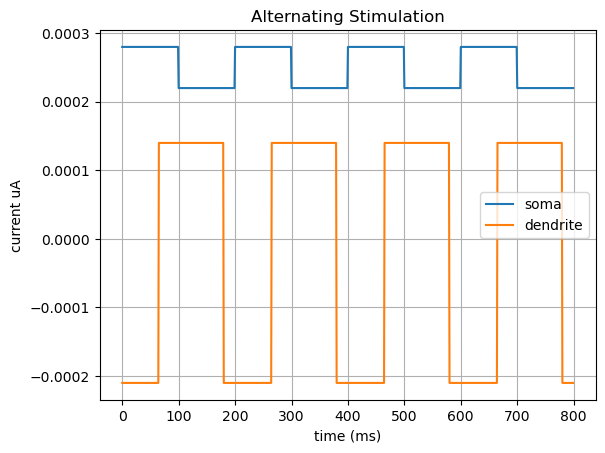

In [12]:
soma_current = get_alternate_current(0, 800, b2.ms, first_amplitude=220*b2.pA, second_amplitude=280*b2.pA, first_duration=100, second_duration=100, frequency=1/200, append_zero=False)
dendrite_current = get_alternate_current(0, 800, b2.ms, first_amplitude=-210*b2.pA, second_amplitude=140*b2.pA, first_duration=85, second_duration=115, frequency=1/200, phase_offset=65,append_zero=False)
plot_sd_alternate_current(soma_current,dendrite_current)

clang-14: error: the clang compiler does not support '-march=native'
WARNING    Cannot use Cython, a test compilation failed: command '/Users/oliviaruggaber/miniconda3/envs/bmnn/bin/arm64-apple-darwin20.0.0-clang' failed with exit code 1 (CompileError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


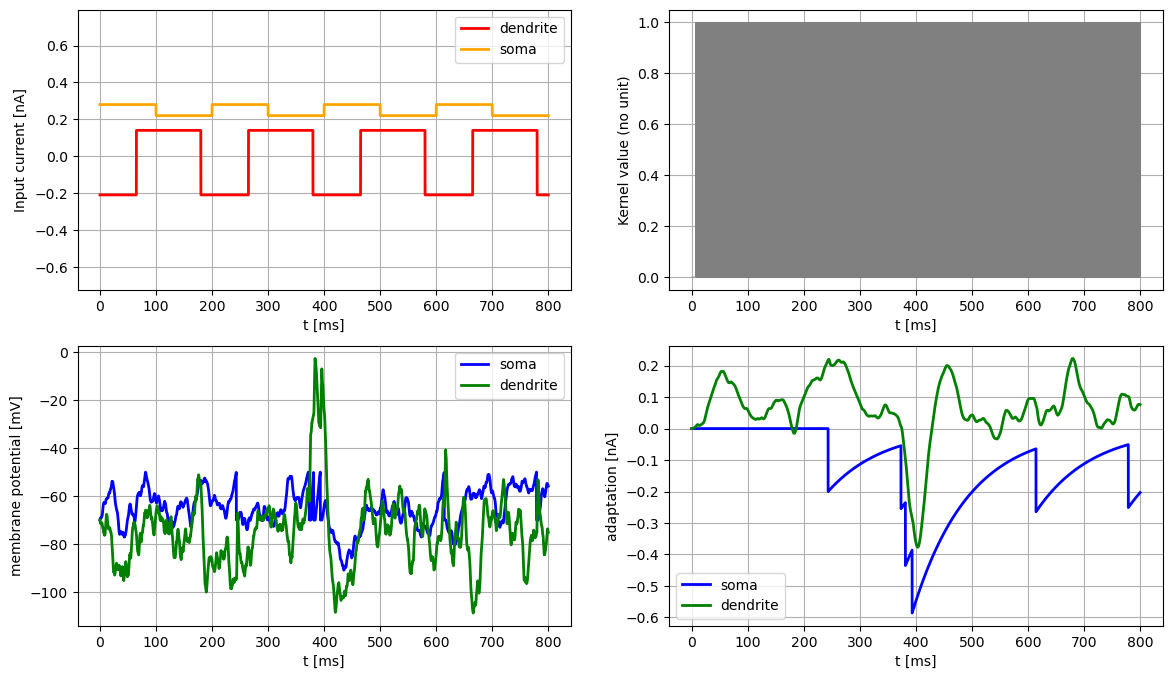

(<Axes: xlabel='t [ms]', ylabel='Input current [nA]'>,
 <Axes: xlabel='t [ms]', ylabel='membrane potential [mV]'>,
 <Axes: xlabel='t [ms]', ylabel='adaptation [nA]'>,
 <Axes: xlabel='t [ms]', ylabel='Kernel value (no unit)'>)

In [5]:
state_monitor, spike_monitor, activation_monitor, deactivation_monitor = simulate_neuron(I_s = soma_current, I_d = dendrite_current)
plot_voltage_activation_and_current_traces(state_monitor, activation_monitor, dendrite_current, soma_current)

In [26]:
def burst_firing_rate(SpikeMonitor, simulation_time, bin_width, burst_interval):
    time_interval = np.arange(0*b2.ms, simulation_time+bin_width, bin_width)

    #firing rate
    population_firing_rate = []
    for i in range(len(time_interval)-1):
        spikes_time = spike_monitor.t[(SpikeMonitor.t > time_interval[i]*b2.second) & (SpikeMonitor.t <= time_interval[i+1]*b2.second)]
        population_firing_rate.append(len(spikes_time)/bin_width)

    #burst rate
    burst_monitor = []
    single_spikes = []
    for neuron in np.unique(SpikeMonitor.i):
        neuron_indexes = np.where(SpikeMonitor.i==neuron)
        neuron_time = SpikeMonitor.t[neuron_indexes[0]]
        #print("1",neuron_time)
        #print(np.split(neuron_time, np.where(np.diff(neuron_time) > burst_interval)[0]+1))
        for event in np.split(neuron_time, np.where(np.diff(neuron_time) > burst_interval)[0]+1):
            if len(event) > 1:
                burst_monitor.append(event[0])
            elif len(event) == 1:
                single_spikes.append(event[0])


    population_burst_rate = []
    single_spike_rate = []
    for i in range(len(time_interval)-1):
        #burst_time = burst_monitor[(burst_monitor > time_interval[i]*b2.second) & (burst_monitor < time_interval[i+1]*b2.second)]
        burst_time = [burst for burst in burst_monitor if time_interval[i]*b2.second <= burst < time_interval[i+1]*b2.second]
        population_burst_rate.append(len(burst_time)/bin_width)
        single_spike_time = [single_spike for single_spike in single_spikes if time_interval[i]*b2.second <= single_spike < time_interval[i+1]*b2.second]
        single_spike_rate.append(len(single_spike_time)/bin_width)

    return population_burst_rate, population_firing_rate, single_spike_rate

In [27]:
simulation_time=800 * b2.ms
bin_width = 1*b2.ms
burst_interval = 16*b2.ms

population_burst_rate, population_firing_rate, single_spike_rate = burst_firing_rate(spike_monitor, simulation_time, bin_width, burst_interval)

window_size = 10*b2.ms
firing_rates_smoothed = np.convolve(population_firing_rate, np.ones(int(window_size/bin_width))*b2.ms/window_size, mode='same')
burst_rates_smoothed = np.convolve(population_burst_rate, np.ones(int(window_size/bin_width))*b2.ms/window_size, mode='same')
single_spike_rate_smoothed = np.convolve(single_spike_rate, np.ones(int(window_size/bin_width))*b2.ms/window_size, mode='same')

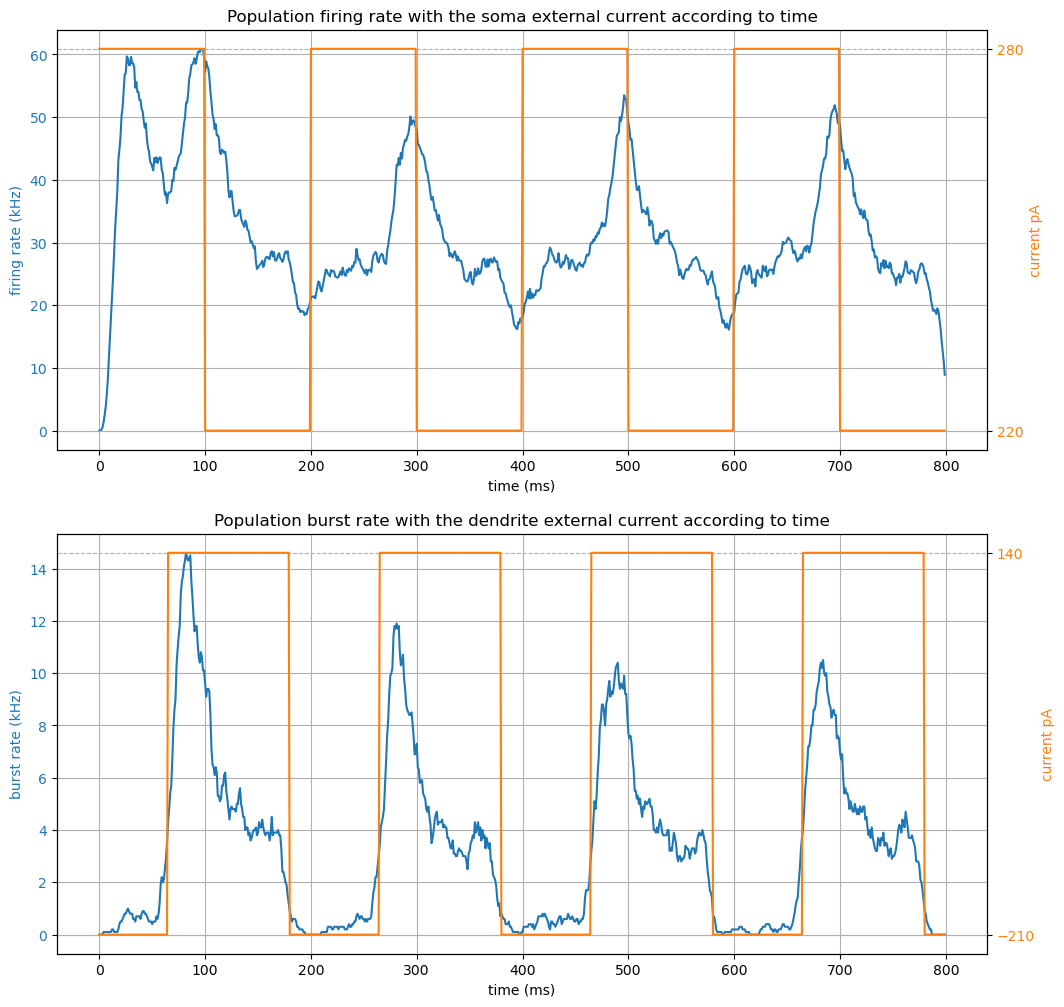

In [28]:
def plot_burst_firing_rates(burst_rate, firing_rate, current_d, current_s, bin_width):
    plt.figure(1, figsize=(12,12))

    ax1 = plt.subplot(211)
    color1 = 'tab:blue'
    ax1.plot(firing_rate*bin_width,color=color1)
    ax1.set_xlabel('time (ms)')
    ax1.set_ylabel('firing rate (kHz)', color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_title('Population firing rate with the soma external current according to time')

    ax2 = ax1.twinx()

    color2 = 'tab:orange'
    ax2.plot(current_s.values / b2.pamp, color=color2)
    ax2.set_ylabel('current pA', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.set_yticks(np.array([np.min(current_s.values / b2.pamp), np.max(current_s.values / b2.pamp)]))

    ax3 = plt.subplot(212)
    color3 = 'tab:blue'
    ax3.plot(burst_rate*bin_width,color=color3)
    ax3.set_xlabel('time (ms)')
    ax3.set_ylabel('burst rate (kHz)', color=color3)
    ax3.tick_params(axis='y', labelcolor=color3)
    ax3.set_title('Population burst rate with the dendrite external current according to time')

    ax4 = ax3.twinx()

    color4 = 'tab:orange'
    ax4.plot(current_d.values / b2.pamp, color=color4)
    ax4.set_ylabel('current pA', color=color4)
    ax4.set_yticks(np.array([np.min(current_d.values / b2.pamp), np.max(current_d.values / b2.pamp)]))
    ax4.tick_params(axis='y', labelcolor=color4)
    
    ax1.grid()
    ax2.grid(ls = '--')
    ax3.grid()
    ax4.grid(ls = '--')
    plt.show()

plot_burst_firing_rates(burst_rates_smoothed, firing_rates_smoothed, dendrite_current, soma_current, bin_width)


## Question 3.4

In [36]:
def burst_probability(SpikeMonitor = None, simulation_time = None, bin_width = None, burst_interval = None, burst_rate = None, single_spike_rate = None):
    if (SpikeMonitor is not None) & (simulation_time is not None) & (bin_width is not None) & (burst_interval is not None) & (burst_rate is None) & (single_spike_rate is None):
        burst, _, single_spike = burst_firing_rate(SpikeMonitor, simulation_time, bin_width, burst_interval)
        event_rate = np.add(burst, single_spike)
        tmp = event_rate
        tmp[np.where(event_rate == 0)[0]] = 1
        burst_prob = np.divide(burst,event_rate)
    elif (burst_rate is not None) & (single_spike_rate is not None) : 
        event_rate = np.add(burst_rate, single_spike_rate)
        tmp = event_rate
        tmp[np.where(event_rate == 0)[0]] = 1
        burst_prob = np.divide(burst_rate,tmp)
    else:
        raise Exception("Invalid input arguments: if you put a Spike Monitor, simulation time, burst width and burst interval need to be provided.")

    return burst_prob, event_rate
    
burst_prob, event_rate = burst_probability(burst_rate = population_burst_rate, single_spike_rate = single_spike_rate)
event_rate_smoothed = np.convolve(event_rate, np.ones(int(window_size/bin_width))*b2.ms/window_size, mode='same')
burst_prob_smoothed = np.convolve(burst_prob, np.ones(int(window_size/bin_width))*b2.ms/window_size, mode='same')

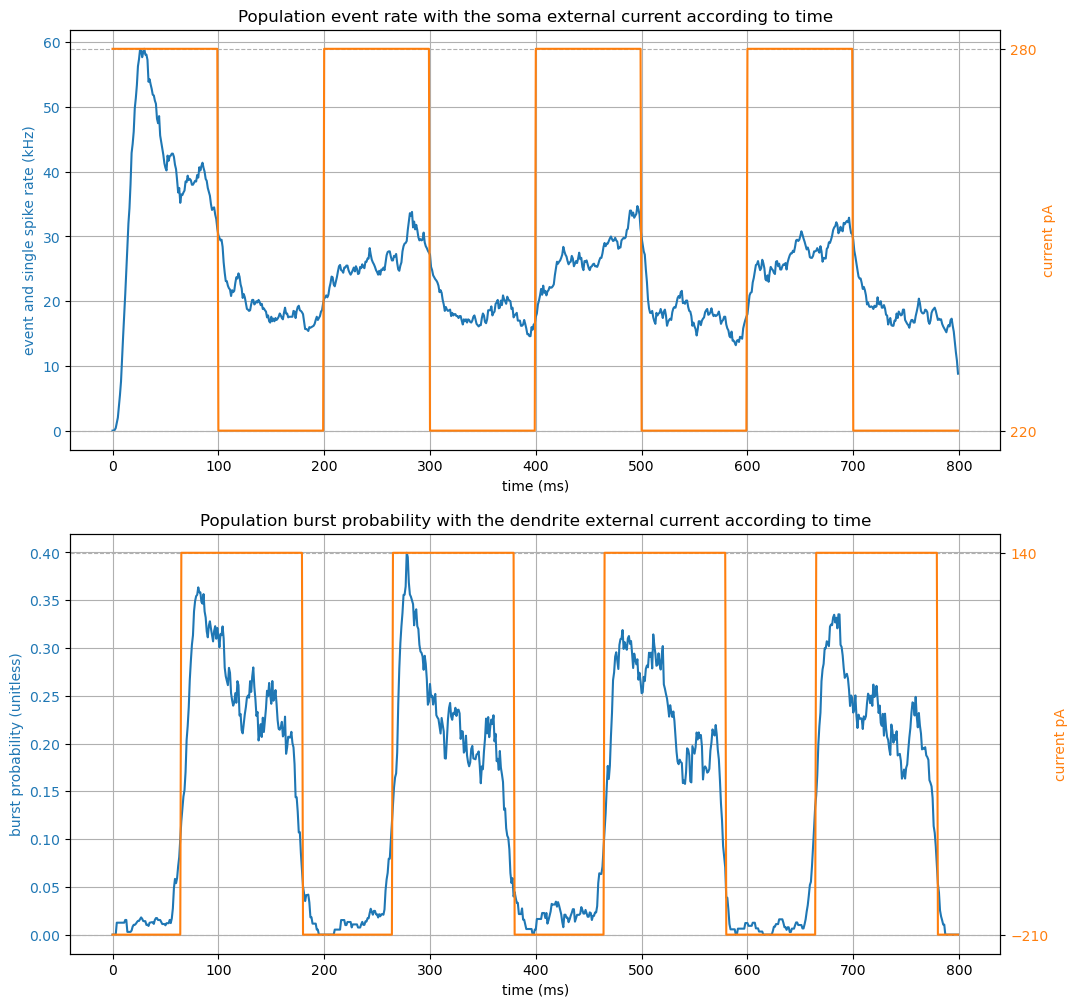

In [41]:
def plot_burst_prob(burst_prob, event_rate, current_d, current_s, bin_width):
    plt.figure(1, figsize=(12,12))

    ax1 = plt.subplot(211)
    color1 = 'tab:blue'
    ax1.plot(event_rate*bin_width,color=color1)
    ax1.set_xlabel('time (ms)')
    ax1.set_ylabel('event and single spike rate (kHz)', color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_title('Population event rate with the soma external current according to time')

    ax2 = ax1.twinx()

    color2 = 'tab:orange'
    ax2.plot(current_s.values / b2.pamp, color=color2)
    ax2.set_ylabel('current pA', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.set_yticks(np.array([np.min(current_s.values / b2.pamp), np.max(current_s.values / b2.pamp)]))

    ax3 = plt.subplot(212)
    color3 = 'tab:blue'
    ax3.plot(burst_prob,color=color3)
    ax3.set_xlabel('time (ms)')
    ax3.set_ylabel('burst probability (unitless)', color=color3)
    ax3.tick_params(axis='y', labelcolor=color3)
    ax3.set_title('Population burst probability with the dendrite external current according to time')

    ax4 = ax3.twinx()

    color4 = 'tab:orange'
    ax4.plot(current_d.values / b2.pamp, color=color4)
    ax4.set_ylabel('current pA', color=color4)
    ax4.set_yticks(np.array([np.min(current_d.values / b2.pamp), np.max(current_d.values / b2.pamp)]))
    ax4.tick_params(axis='y', labelcolor=color4)
    
    ax1.grid()
    ax2.grid(ls = '--')
    ax3.grid()
    ax4.grid(ls = '--')
    plt.show()

plot_burst_prob(burst_prob_smoothed, event_rate_smoothed, dendrite_current, soma_current, bin_width)


# Bonus

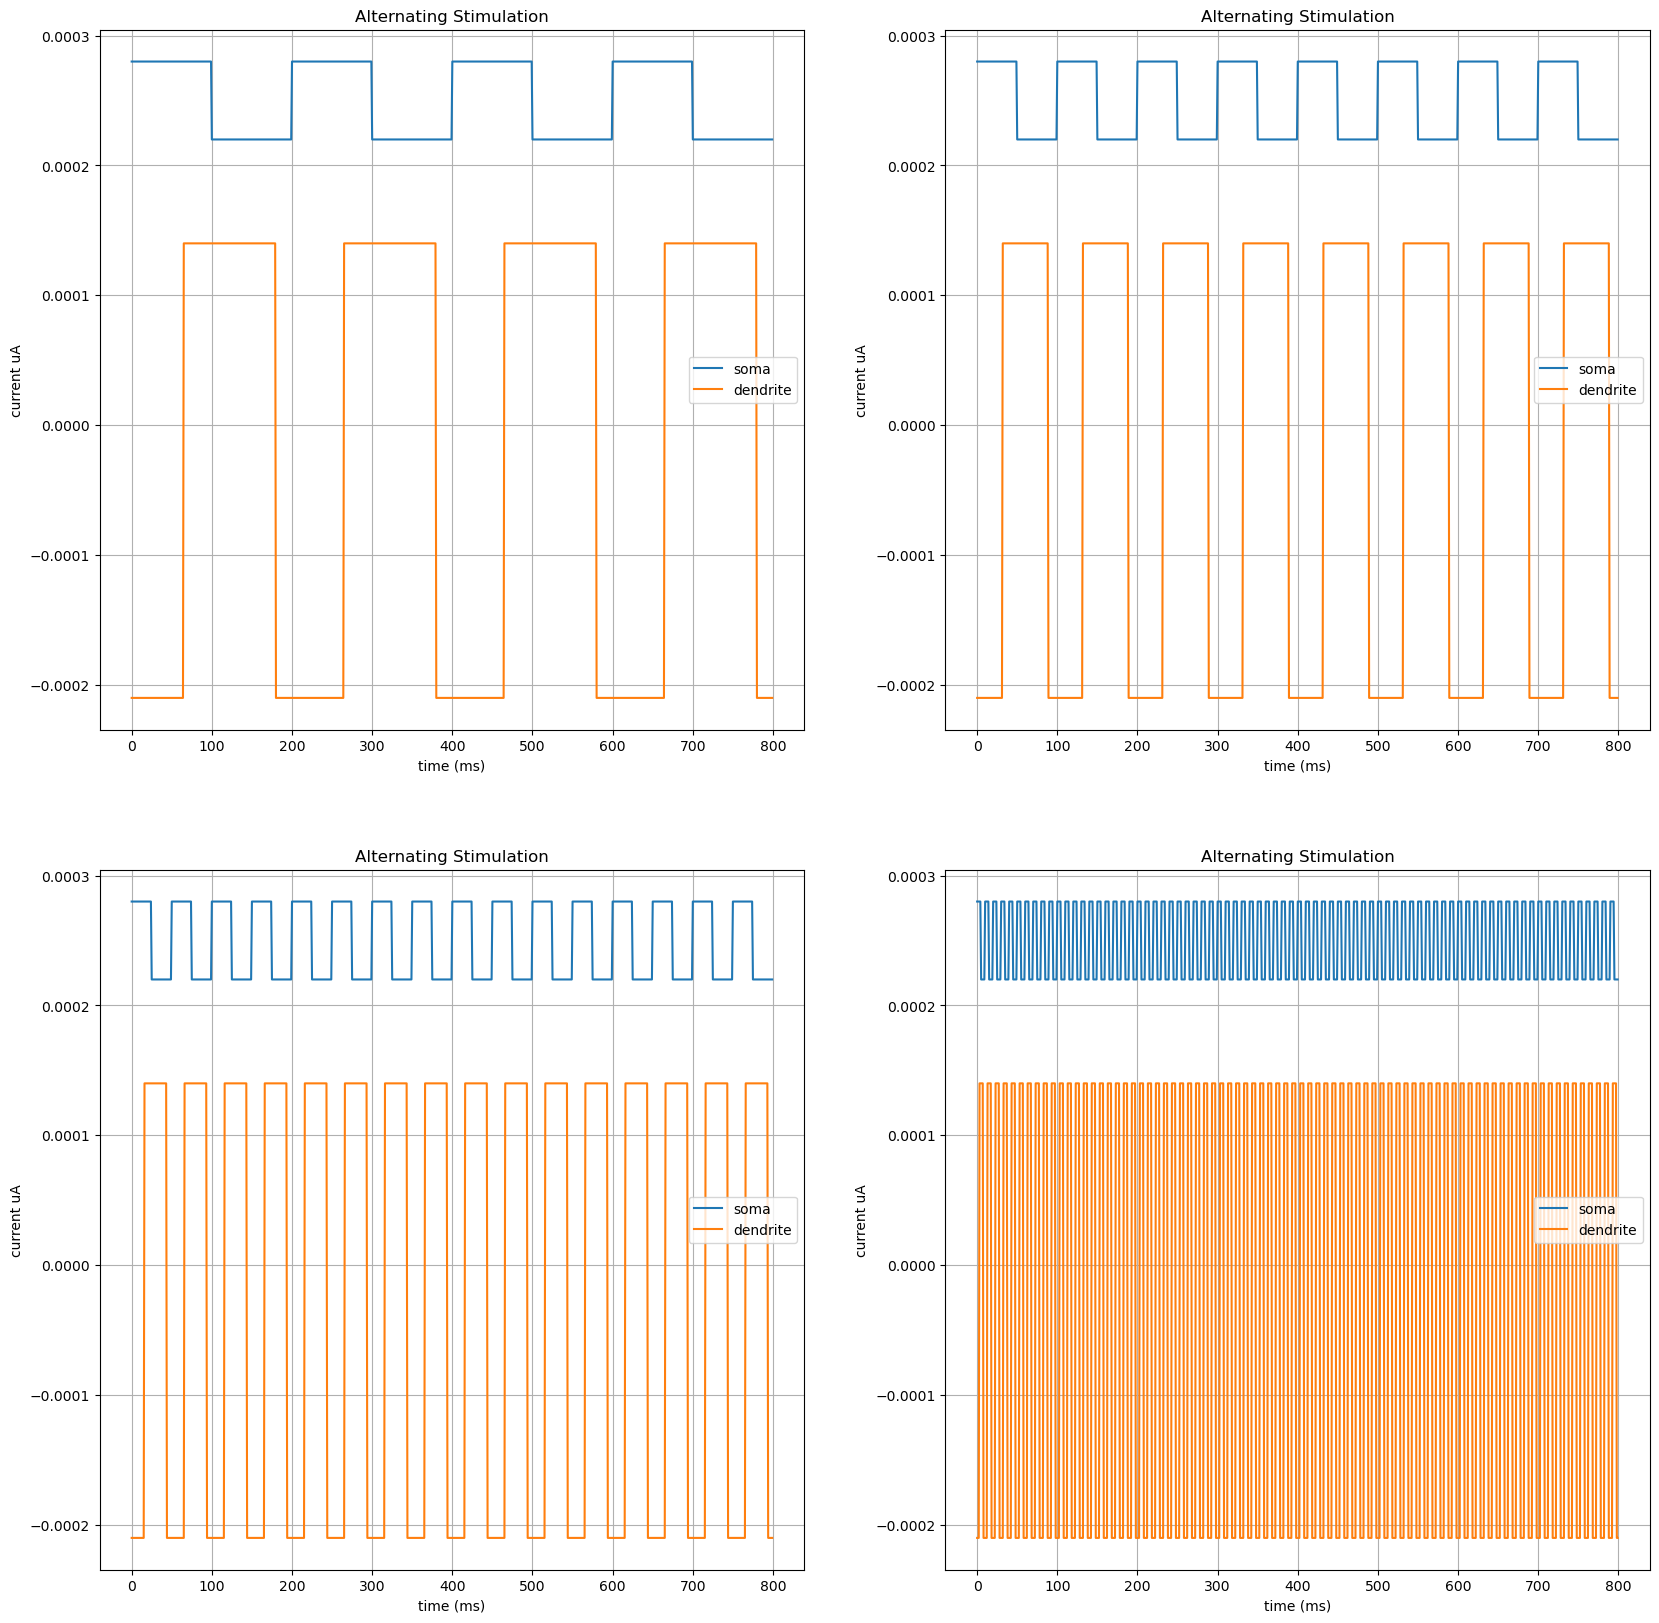

In [21]:
factors = [1,1/2,1/4,1/20]

fig, ax = plt.subplots(2, 2, figsize=(20, 20))

axe = ax.flatten()
for i,f in enumerate(factors):
    soma_current = get_alternate_current(0, 800, b2.ms, first_amplitude=220*b2.pA, second_amplitude=280*b2.pA, first_duration=int(100*f), second_duration=int(100*f), frequency=1/200*1/f, append_zero=False)
    dendrite_current = get_alternate_current(0, 800, b2.ms, first_amplitude=-210*b2.pA, second_amplitude=140*b2.pA, first_duration=int(85*f), second_duration=int(115*f), frequency=1/200*1/f, phase_offset=int(65*f),append_zero=False)
    axe[i].plot(soma_current.values / b2.uamp, label ="soma")
    axe[i].plot(dendrite_current.values / b2.uamp, label ="dendrite")
    axe[i].set_title("Alternating Stimulation")
    axe[i].set_xlabel("time (ms)")
    axe[i].set_ylabel("current uA")
    axe[i].grid()
    axe[i].legend()